In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# HSCP Protocol

## Pixel GT

In [2]:
from utils.hscp_eval import hscp_pixel_eval

gt_img = cv2.imread("./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test/032.png", cv2.IMREAD_GRAYSCALE)
pred_img = cv2.imread("./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test/032.png", cv2.IMREAD_GRAYSCALE)

dr, ra, fm = hscp_pixel_eval(gt_img, pred_img)

print(f"HSCP -> DR: {dr:.2f}, RA: {ra:.2f}, FM: {fm:.2f}")

ModuleNotFoundError: No module named 'helpers'

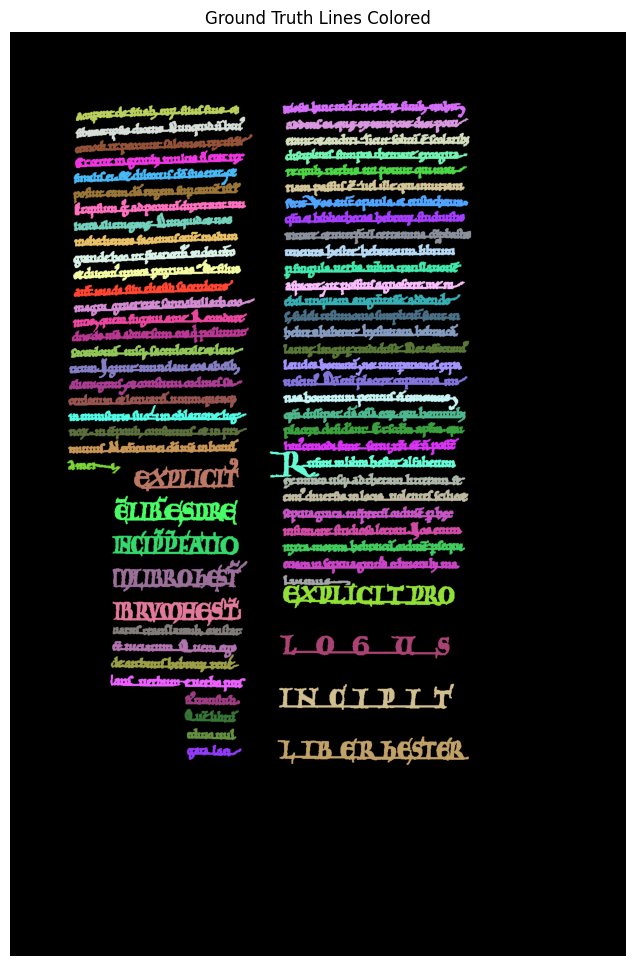

In [29]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the binary image
gt_img = cv2.imread("./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test/032.png", cv2.IMREAD_GRAYSCALE)

# Convert to binary (just in case)
# _, gt_bin = cv2.threshold(gt_img, 0, 255, cv2.THRESH_BINARY)

# Label connected components
num_labels, labels_im = cv2.connectedComponents(gt_img)

# Create a color image
h, w = gt_img.shape
color_img = np.zeros((h, w, 3), dtype=np.uint8)

# Assign random color for each connected component (skip background label 0)
for label in range(1, num_labels):
    mask = labels_im == label
    color = [random.randint(50, 255) for _ in range(3)]
    color_img[mask] = color

# Display
plt.figure(figsize=(12, 12))
plt.imshow(color_img)
plt.axis("off")
plt.title("Ground Truth Lines Colored")
plt.show()


## XML GT

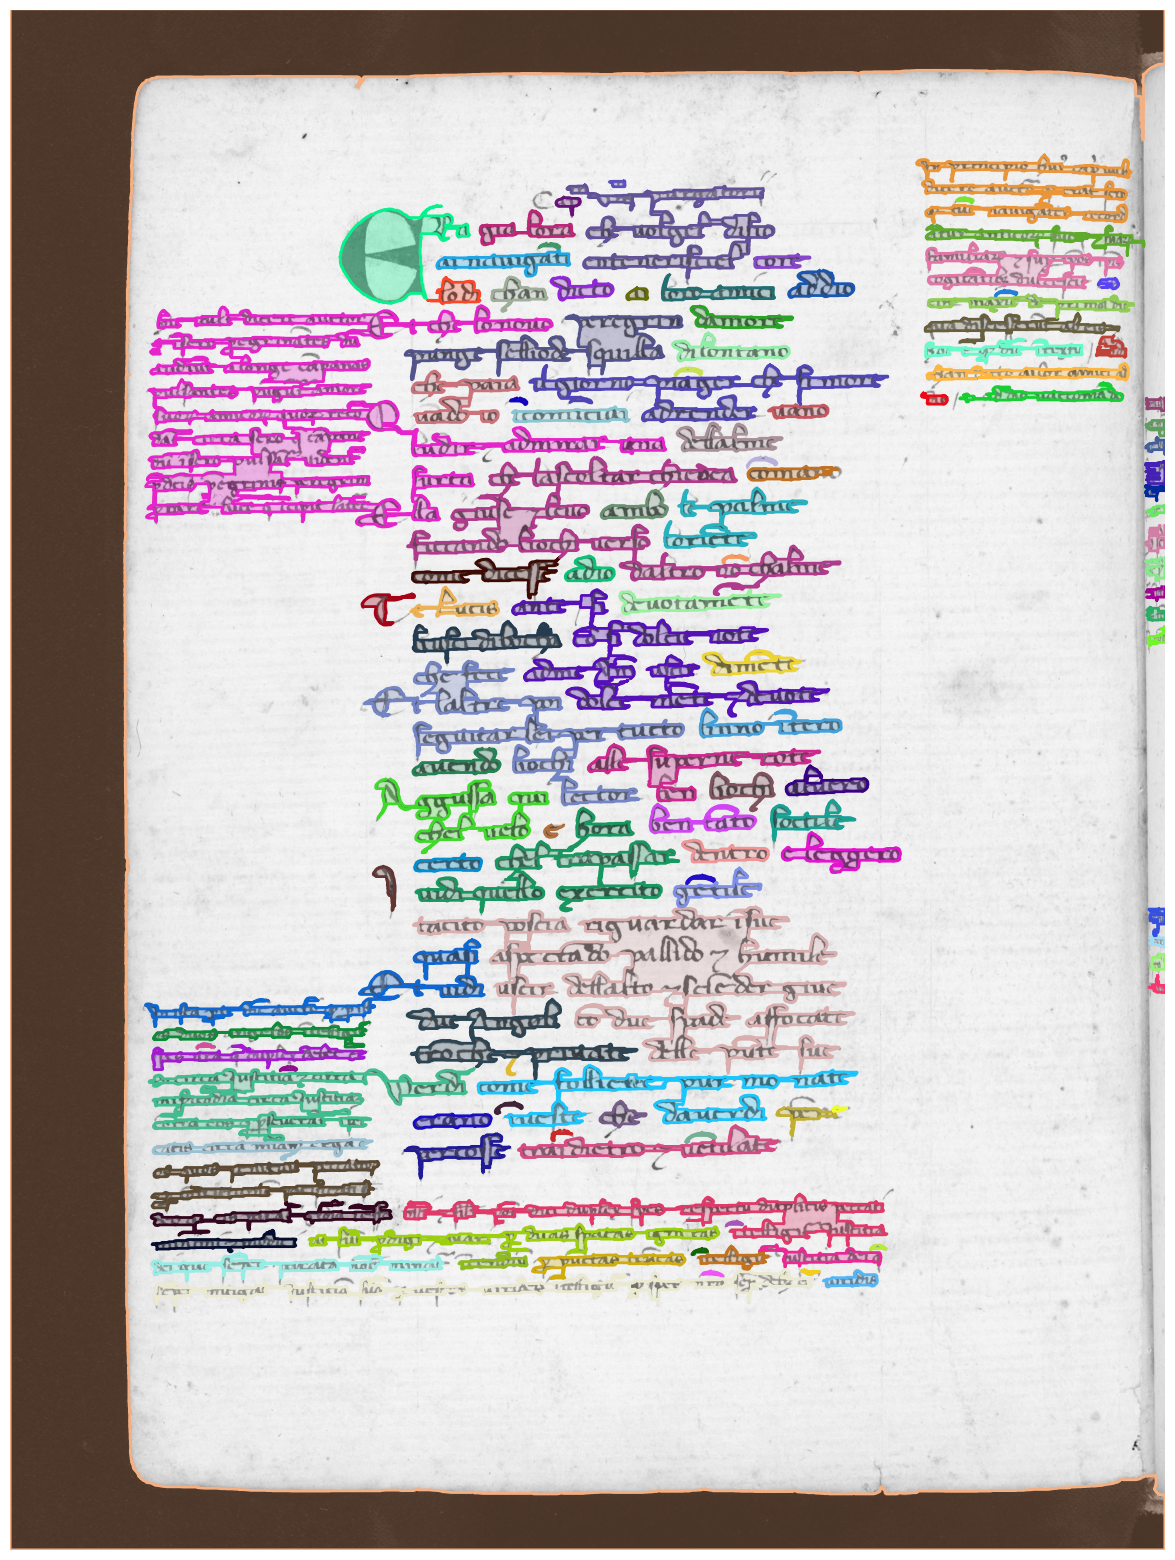

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def simple_segmentation(image_path):
    # 1. Load grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 2. Threshold (Otsu)
    _, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3. Morphological closing (connect text strokes into lines)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 3))
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

    # 4. Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 500:  # filter noise
            continue
        coords = [(int(x), int(y)) for x, y in cnt.squeeze()]
        polygons.append(coords)

    return img, polygons


def plot_polygons(img, polygons):
    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap="gray")

    for poly in polygons:
        poly_arr = np.array(poly)
        # random RGB color
        color = [random.random(), random.random(), random.random()]
        # filled polygon with alpha
        plt.fill(poly_arr[:,0], poly_arr[:,1], color=color, alpha=0.3)
        # polygon border
        plt.plot(poly_arr[:,0], poly_arr[:,1], color=color, linewidth=2)

    plt.axis("off")
    plt.show()

# --- Example usage ---
img, polygons = simple_segmentation("./data/DIVA-HIsDB/img-CB55/img/public-test/e-codices_fmb-cb-0055_0098v_max.jpg")
plot_polygons(img, polygons)


In [ ]:
from utils.hscp_eval import hscp_xml_eval
from utils.diva_eval import diva_xml_eval

gt_xml = "./data/DIVA-HIsDB/PAGE-gt-CB55-TASK-2/TASK-2/public-test/e-codices_fmb-cb-0055_0098v_max.xml"
# pred_xml = "./data/DIVA-HIsDB/PAGE-gt-CB55-TASK-2/TASK-2/public-test/e-codices_fmb-cb-0055_0098v_max.xml"
pred_xml = "./test_pred.xml"
# --- HSCP evaluation ---
dr, ra, fm = hscp_xml_eval(gt_xml, pred_xml, threshold=0.75)
print(f"HSCP -> DR: {dr:.4f}, RA: {ra:.4f}, FM: {fm:.4f}")

# --- DIVA evaluation ---
# Make sure to set image_shape to your document resolution
piu, liu = diva_xml_eval(gt_xml, pred_xml, threshold=0.75)
print(f"DIVA -> Pixel IoU (PIU): {piu:.4f}, Line IoU (LIU): {liu:.4f}")


HSCP -> DR: 0.0000, RA: 0.0000, FM: 0.0000
DIVA -> Pixel IoU (PIU): 0.2348, Line IoU (LIU): 0.0000


In [6]:
import cv2
import xml.etree.ElementTree as ET

# --- Set paths ---
img_path = "./data/DIVA-HIsDB/img-CB55/img/public-test/e-codices_fmb-cb-0055_0098v_max.jpg"

# --- Simple segmentation (JPG -> polygons) ---
def simple_segmentation(image_path, min_area=500, morph_kernel=(50,3)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue
        coords = [(int(x), int(y)) for x, y in cnt.squeeze()]
        polygons.append(coords)
    return polygons

# --- Extract baseline from polygon ---
def polygon_to_baseline(poly):
    """
    Simple heuristic: baseline is a horizontal line at the bottom of the polygon
    from the left-most to right-most points.
    """
    poly_sorted = sorted(poly, key=lambda p: p[0])  # sort by x
    y_bottom = max(y for _, y in poly)
    x0 = poly_sorted[0][0]
    x1 = poly_sorted[-1][0]
    return [(x0, y_bottom), (x1, y_bottom)]

# --- Save polygons and baselines to PAGE XML ---
import xml.etree.ElementTree as ET

def save_pred_xml(polygons, xml_path, image_filename="image.png"):
    ns = "http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15"
    xsi = "http://www.w3.org/2001/XMLSchema-instance"
    schema_location = f"{ns} {ns}/pagecontent.xsd"
    ET.register_namespace('', ns)
    ET.register_namespace('xsi', xsi)

    root = ET.Element(f"{{{ns}}}PcGts", {f"{{{xsi}}}schemaLocation": schema_location})

    metadata = ET.SubElement(root, f"{{{ns}}}Metadata")
    ET.SubElement(metadata, f"{{{ns}}}Creator").text = "Fotini Simistira"
    ET.SubElement(metadata, f"{{{ns}}}Created").text = "2016-06-16T14:51:24.007Z"
    ET.SubElement(metadata, f"{{{ns}}}LastChange").text = "2017-02-14T13:04:02.673Z"
    # Page element
    page = ET.SubElement(root, f"{{{ns}}}Page",
                         imageWidth="4872",
                         imageHeight="6496",
                         imageFilename='e-codices_fmb-cb-0055_0098v_max.jpg')

    # Single TextRegion
    text_region = ET.SubElement(page, f"{{{ns}}}TextRegion", id="region_textline", custom = '0')

    all_x = [x for poly in polygons for x, y in poly]
    all_y = [y for poly in polygons for x, y in poly]
    region_coords = [(min(all_x), min(all_y)), (max(all_x), min(all_y)),
                     (max(all_x), max(all_y)), (min(all_x), max(all_y))]
    coords_str = " ".join([f"{x},{y}" for x, y in region_coords])
    ET.SubElement(text_region, f"{{{ns}}}Coords", points=coords_str)

    # Take only first polygon

    for idx, poly in enumerate(polygons):
        # TextLine
        text_line = ET.SubElement(text_region, f"{{{ns}}}TextLine", id=f"textline_{idx}", custom="0")
        coords_str = " ".join([f"{x},{y}" for x, y in poly])
        ET.SubElement(text_line, f"{{{ns}}}Coords", points=coords_str)

        # Baseline (approx: leftmost & rightmost x, average y)
        min_x = min(x for x, y in poly)
        max_x = max(x for x, y in poly)
        avg_y = int(sum(y for x, y in poly) / len(poly))
        baseline_str = f"{min_x},{avg_y} {max_x},{avg_y}"
        ET.SubElement(text_line, f"{{{ns}}}Baseline", points=baseline_str)

        # TextEquiv
        text_equiv = ET.SubElement(text_line, f"{{{ns}}}TextEquiv")
        ET.SubElement(text_equiv, f"{{{ns}}}Unicode")

    tree = ET.ElementTree(root)
    tree.write(xml_path, encoding="UTF-8", xml_declaration=True)
# --- Run ---
polygons = simple_segmentation(img_path)
pred_xml_path = "./test_pred.xml"
save_pred_xml(polygons, pred_xml_path)